In [28]:
from gurobipy import *
import  matplotlib.pyplot as plt
import numpy as np



# Exercice 1
## 1.1) maxmin


\begin{align*}
\max \quad & t \\
\text{sous contraintes} \quad & t \leq \sum_{i=1}^{n} v_{i,1} x_i \\
& t \leq \sum_{i=1}^{n} v_{i,2} x_i \\
& \sum_{i=1}^{n} w_i x_i \leq W \\
& x_i \in \{0, 1\}, \quad \forall i = 1, \ldots, n
\end{align*}



In [29]:
c = 100
valeurs_scenarios = [[70,18,16,14,12,10,8,6,4,2],
                    [2,4,6,8,10,12,14,16,18,70]]
p = [60,10,15,20,25,20,5,15,20,60]
n = list(set([len(s) for s in valeurs_scenarios]))
assert len(n) == 1, "Nombre des objets scénarios n'est pas égal"
n = n[0]
assert n == len(p), "Nombre des objects et poids n'est pas égale"

In [30]:
def model_sad_maxmin(c,valeurs_scenarios, p):
    model = Model()
    model.params.LogToConsole = False

    t = model.addVar(vtype = GRB.INTEGER)
    x = model.addVars(n, vtype=GRB.BINARY)

    model.setObjective(t, GRB.MAXIMIZE)

    model.addConstr(quicksum(p[i] * x[i] for i in range(n)) <= c) # contraint de poids maximum

    for s_p in valeurs_scenarios:
        model.addConstr(t <= quicksum(s_p[i] * x[i] for i in range(n))) # contraint de valeur minimale pour scénario s

    model.optimize()
    objets_selectiones = [i for i in range(n) if x[i].X > 0.5]
    profit = int(model.objVal)

    vecteur_image_z = []
    for v_s in valeurs_scenarios:
        vecteur_image_z.append(sum([v for i,v in enumerate(v_s) if i in objets_selectiones]))

    return {'vecteur_z':vecteur_image_z, 'objets': objets_selectiones, 'profit': profit}

In [31]:
model_sad_maxmin(c,valeurs_scenarios,p)

{'vecteur_z': [66, 66], 'objets': [1, 2, 3, 6, 7, 8], 'profit': 66}

## 1.2) minmax regret

\begin{align*}
\min \quad & t \\
\text{sous contraintes} \quad & t \geq z_1^* - \sum_{i=1}^{n} v_{i,1} x_i \\
& t \geq z_2^* - \sum_{i=1}^{n} v_{i,2} x_i \\
& \sum_{i=1}^{n} w_i x_i \leq W \\
& x_i \in \{0, 1\}, \quad \forall i = 1, \ldots, n
\end{align*}

$z_i^*$ étant la meilleure valeure pour le scénario i 

In [32]:
def model_sad_regret(c,valeurs_scenarios, p):

        # trouver les meilleures solutions pour chaque scénario
    z_etoile = []
    for v_s in valeurs_scenarios:
        #print(v_s)
        gurobi_solution = model_sad_maxmin(c, [v_s], p) # model_sad_maxmin avec un scénario est égal à optimiser le problème sad
        z_etoile.append(gurobi_solution['profit'])
    #print('Z_Etoile', z_etoile)

    model = Model()
    model.params.LogToConsole = False
    t = model.addVar(vtype = GRB.INTEGER)
    x = model.addVars(n, vtype=GRB.BINARY)

    model.setObjective(t, GRB.MINIMIZE)

    model.addConstr(quicksum(p[i] * x[i] for i in range(n)) <= c) # contraint de poids maximum

    for i, s_p in enumerate(valeurs_scenarios):
        model.addConstr(t >= z_etoile[i] - quicksum(s_p[i] * x[i] for i in range(n))) # contraint de regret maximale pour scénario s

    model.optimize()
    objets_selectiones = [i for i in range(n) if x[i].X > 0.5]
    min_regret = int(model.objVal)

    vecteur_image_z = []
    for v_s in valeurs_scenarios:
        vecteur_image_z.append(sum([v for i,v in enumerate(v_s) if i in objets_selectiones]))

    return {'vecteur_z':vecteur_image_z, 'objets': objets_selectiones, 'min_regret': min_regret, 'profit': min(vecteur_image_z), 'z_etoile': z_etoile}

In [33]:
sol_regret = model_sad_regret(c,valeurs_scenarios,p)
z_etoile = sol_regret['z_etoile']
sol_regret

{'vecteur_z': [62, 70],
 'objets': [1, 2, 5, 6, 7, 8],
 'min_regret': 50,
 'profit': 62,
 'z_etoile': [112, 118]}

## 1.3)

z_etoile  [112, 118]
vecteur z [62, 70]


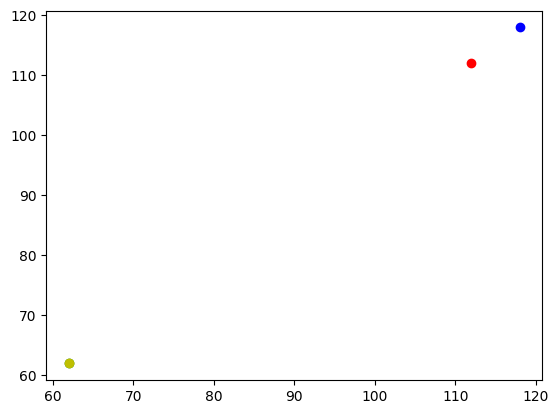

In [34]:
print("z_etoile ", z_etoile)
print("vecteur z", sol_regret['vecteur_z'])
plt.plot(z_etoile[0],z_etoile[0],'ro')
plt.plot(z_etoile[1],z_etoile[1],'bo')
plt.plot(sol_regret['vecteur_z'][0],sol_regret['vecteur_z'][0], 'go')
plt.plot(sol_regret['vecteur_z'][0],sol_regret['vecteur_z'][0], 'yo')

## ??????

## 1.4)

In [35]:

def generate_instances(n_values, p_values, num_instances=1, cost_range=(1, 100), utility_range=(1, 100)):
    instances = []
    for n in n_values:
        for p in p_values:
            for _ in range(num_instances):
                # Générer les coûts des projets
                costs = np.random.randint(cost_range[0], cost_range[1] + 1, size=p)
                
                # Calculer le budget à 50% du coût total des projets
                budget = int(0.5 * np.sum(costs))
                
                # Générer les utilités des projets pour chaque scénario
                utilities = np.random.randint(utility_range[0], utility_range[1] + 1, size=(n, p))
                
                # Enregistrer l'instance avec coûts, utilités et budget
                instance = {
                    'n': n,
                    'p': p,
                    'cout': costs,
                    'budget': budget,
                    'valeurs': utilities
                }
                instances.append(instance)
    return instances

# Exemple d'utilisation
n_values = [5, 10, 15]  # Nombre de scénarios
p_values = [10, 15, 20] # Nombre de projets

instances = generate_instances(n_values, p_values)
len(instances)
instances

model_sad_maxmin(c = instances[0]['budget'], valeurs_scenarios=instances[0]['valeurs'], p=instances[0]['cout'])


{'vecteur_z': [np.int64(250),
  np.int64(243),
  np.int64(315),
  np.int64(247),
  np.int64(295)],
 'objets': [2, 4, 6, 7, 8, 9],
 'profit': 243}

(n=15, p=10) - Temps moyen maxmin: 0.0061 s, Temps moyen regret: 0.0466 s
(n=15, p=15) - Temps moyen maxmin: 0.0037 s, Temps moyen regret: 0.0387 s
(n=15, p=20) - Temps moyen maxmin: 0.0015 s, Temps moyen regret: 0.0063 s
(n=10, p=10) - Temps moyen maxmin: 0.0042 s, Temps moyen regret: 0.0355 s
(n=10, p=15) - Temps moyen maxmin: 0.0063 s, Temps moyen regret: 0.0280 s
(n=10, p=20) - Temps moyen maxmin: 0.0012 s, Temps moyen regret: 0.0041 s
(n=5, p=10) - Temps moyen maxmin: 0.0023 s, Temps moyen regret: 0.0140 s
(n=5, p=15) - Temps moyen maxmin: 0.0023 s, Temps moyen regret: 0.0158 s
(n=5, p=20) - Temps moyen maxmin: 0.0019 s, Temps moyen regret: 0.0042 s


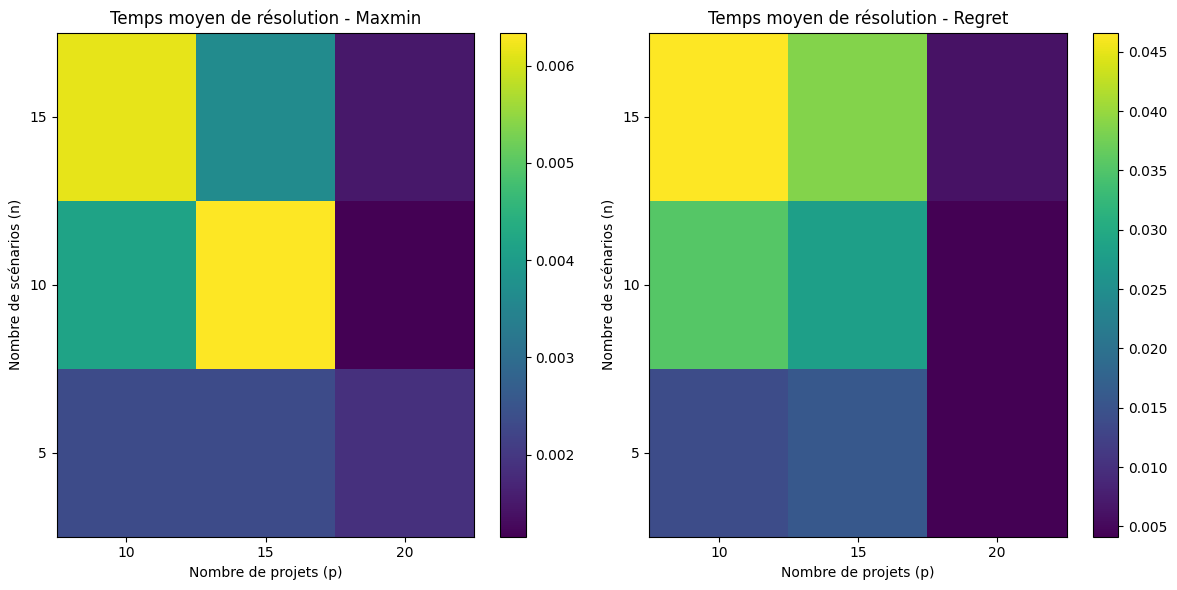

In [36]:
import time


def average_resolution_time(model_function, instances):
    """Calcule le temps moyen de résolution pour un ensemble d'instances donné avec un modèle spécifique."""
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        # Appeler la fonction modèle pour résoudre l'instance
        model_function(c = instances[0]['budget'], valeurs_scenarios=instances[0]['valeurs'], p=instances[0]['cout'])
        
        end_time = time.time()
        total_time += (end_time - start_time)
    
    # Calculer le temps moyen pour les 10 instances
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            # Générer 10 instances pour le couple (n, p)
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # Calculer le temps moyen pour le modèle maxmin
            avg_time_maxmin = average_resolution_time(model_sad_maxmin, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            # Calculer le temps moyen pour le modèle regret
            avg_time_regret = average_resolution_time(model_sad_regret, instances)
            regret_times[i, j] = avg_time_regret
            
            print(f"(n={n}, p={p}) - Temps moyen maxmin: {avg_time_maxmin:.4f} s, Temps moyen regret: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, n_values, p_values

def plot_results(maxmin_times, regret_times, n_values, p_values):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Heatmap pour le modèle maxmin
    im1 = axs[0].imshow(maxmin_times, cmap='viridis', aspect='auto')
    axs[0].set_title("Temps moyen de résolution - Maxmin")
    axs[0].set_xlabel("Nombre de projets (p)")
    axs[0].set_ylabel("Nombre de scénarios (n)")
    axs[0].set_xticks(np.arange(len(p_values)))
    axs[0].set_yticks(np.arange(len(n_values)))
    axs[0].set_xticklabels(p_values)
    axs[0].set_yticklabels(n_values)
    fig.colorbar(im1, ax=axs[0], orientation='vertical')
    
    # Heatmap pour le modèle regret
    im2 = axs[1].imshow(regret_times, cmap='viridis', aspect='auto')
    axs[1].set_title("Temps moyen de résolution - Regret")
    axs[1].set_xlabel("Nombre de projets (p)")
    axs[1].set_ylabel("Nombre de scénarios (n)")
    axs[1].set_xticks(np.arange(len(p_values)))
    axs[1].set_yticks(np.arange(len(n_values)))
    axs[1].set_xticklabels(p_values)
    axs[1].set_yticklabels(n_values)
    fig.colorbar(im2, ax=axs[1], orientation='vertical')
    
    plt.tight_layout()
    plt.show()

# Paramètres d'entrée
n_values = [15, 10, 5]  # Nombre de scénarios
p_values = [10, 15, 20] # Nombre de projets

# Lancer l'évaluation du temps moyen de résolution
maxmin_times, regret_times, n_values, p_values = main(n_values, p_values)

# Afficher les résultats avec matplotlib
plot_results(maxmin_times, regret_times, n_values, p_values)


(n=5, p=10) - Avg time maxmin: 0.0034 s, Avg time regret: 0.0179 s
(n=5, p=15) - Avg time maxmin: 0.0025 s, Avg time regret: 0.0090 s
(n=5, p=20) - Avg time maxmin: 0.0006 s, Avg time regret: 0.0021 s
(n=10, p=10) - Avg time maxmin: 0.0028 s, Avg time regret: 0.0229 s
(n=10, p=15) - Avg time maxmin: 0.0027 s, Avg time regret: 0.0156 s
(n=10, p=20) - Avg time maxmin: 0.0021 s, Avg time regret: 0.0206 s
(n=15, p=10) - Avg time maxmin: 0.0051 s, Avg time regret: 0.0389 s
(n=15, p=15) - Avg time maxmin: 0.0043 s, Avg time regret: 0.0487 s
(n=15, p=20) - Avg time maxmin: 0.0039 s, Avg time regret: 0.0070 s


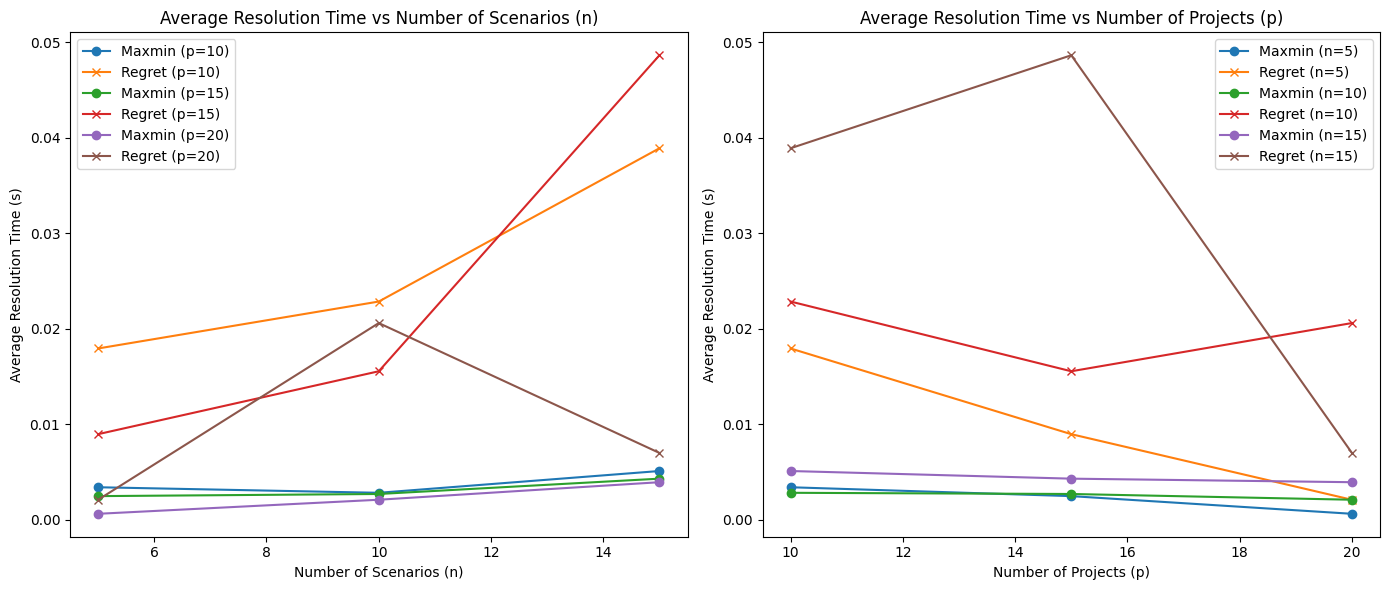

In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt

def average_resolution_time(model_function, instances):
    """Calculate the average resolution time for a given set of instances with a specific model."""
    total_time = 0
    for instance in instances:
        start_time = time.time()
        
        # Call the model function to solve the instance
        model_function(c = instances[0]['budget'], valeurs_scenarios=instances[0]['valeurs'], p=instances[0]['cout'])
        
        end_time = time.time()
        total_time += (end_time - start_time)
    
    # Calculate the average time for the 10 instances
    avg_time = total_time / len(instances)
    return avg_time

def main(n_values, p_values, num_instances=10):
    maxmin_times = np.zeros((len(n_values), len(p_values)))
    regret_times = np.zeros((len(n_values), len(p_values)))
    
    for i, n in enumerate(n_values):
        for j, p in enumerate(p_values):
            # Generate 10 instances for the (n, p) pair
            instances = generate_instances([n], [p], num_instances=num_instances)
            
            # Calculate average time for the maxmin model
            avg_time_maxmin = average_resolution_time(model_sad_maxmin, instances)
            maxmin_times[i, j] = avg_time_maxmin
            
            # Calculate average time for the regret model
            avg_time_regret = average_resolution_time(model_sad_regret, instances)
            regret_times[i, j] = avg_time_regret
            
            print(f"(n={n}, p={p}) - Avg time maxmin: {avg_time_maxmin:.4f} s, Avg time regret: {avg_time_regret:.4f} s")
    
    return maxmin_times, regret_times, n_values, p_values

def plot_comparison_line(maxmin_times, regret_times, n_values, p_values):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Average time vs number of scenarios (n) for each p
    for j, p in enumerate(p_values):
        axs[0].plot(n_values, maxmin_times[:, j], label=f"Maxmin (p={p})", marker='o')
        axs[0].plot(n_values, regret_times[:, j], label=f"Regret (p={p})", marker='x')
    
    axs[0].set_title("Average Resolution Time vs Number of Scenarios (n)")
    axs[0].set_xlabel("Number of Scenarios (n)")
    axs[0].set_ylabel("Average Resolution Time (s)")
    axs[0].legend()
    
    # Plot 2: Average time vs number of projects (p) for each n
    for i, n in enumerate(n_values):
        axs[1].plot(p_values, maxmin_times[i, :], label=f"Maxmin (n={n})", marker='o')
        axs[1].plot(p_values, regret_times[i, :], label=f"Regret (n={n})", marker='x')
    
    axs[1].set_title("Average Resolution Time vs Number of Projects (p)")
    axs[1].set_xlabel("Number of Projects (p)")
    axs[1].set_ylabel("Average Resolution Time (s)")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# Input parameters
n_values = [5, 10, 15]  # Number of scenarios
p_values = [10, 15, 20] # Number of projects

# Run the evaluation of average resolution times
maxmin_times, regret_times, n_values, p_values = main(n_values, p_values)

# Plot the comparison using line plots
plot_comparison_line(maxmin_times, regret_times, n_values, p_values)
